# 102 Flowers Classification

In this notebook, we classify the 102 flowers dataset. We'll do the same procedures done in `17flowers.ipynb`, so the sections will be more straighforward.

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import scipy.io

2023-05-09 16:31:29.221103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 16:31:29.971209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Preprocessing

### Class distribution

Since the categories are not evenly distributed, let's have a look at their distribution.

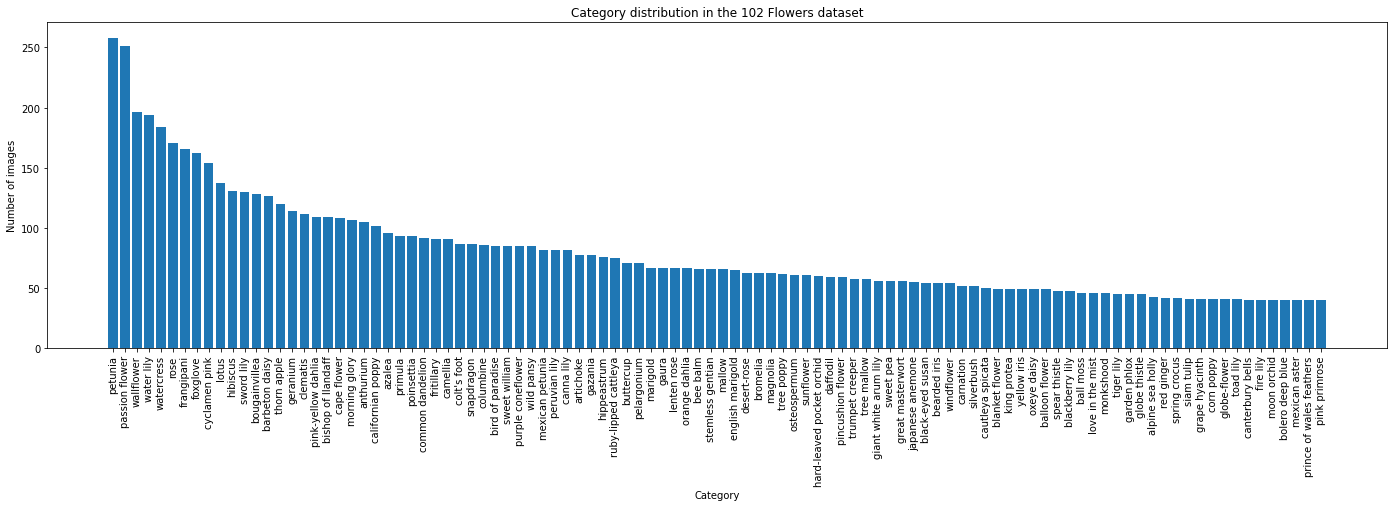

In [2]:
mat = scipy.io.loadmat('./data/102flowers/imagelabels.mat')
mat_labels = mat["labels"][0]

# list of class labels
with open("102flowers_labels.txt", "r") as f:
    flower_labels = [line.strip() for line in f]

# Count number of images per class
class_count = np.zeros(102)
for i in range(len(mat_labels)):
    class_count[mat_labels[i]-1] += 1

# Sort the data in descending order
sorted_indices = np.argsort(class_count)[::-1]
sorted_x = [flower_labels[i] for i in sorted_indices]
sorted_y = [class_count[i] for i in sorted_indices]

# Plot
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(111)
plt.bar(sorted_x, sorted_y)
plt.xticks(rotation=90)
plt.title("Category distribution in the 102 Flowers dataset")
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.show()

In [3]:
print(f"{len(mat_labels)} images.")

8189 images.


### Create the training and validation datasets

In [6]:
# set the path to the folder containing the images
path_to_data = "data/102flowers/"

train_dir = pathlib.Path(path_to_data + "train")
val_dir = pathlib.Path(path_to_data + "val")
test_dir = pathlib.Path(path_to_data + "test")

batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 1020 files belonging to 102 classes.
Found 1020 files belonging to 102 classes.


2023-05-09 16:31:34.200416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 16:31:34.232282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 16:31:34.232437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 6149 files belonging to 102 classes.


Verify class names are correct:

In [7]:
class_names = train_ds.class_names

assert sorted(class_names) == sorted(flower_labels)

### Visualize the data

Here are the first 9 images from the training dataset.

2023-05-09 16:31:35.721516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1020]
	 [[{{node Placeholder/_4}}]]
2023-05-09 16:31:35.721983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1020]
	 [[{{node Placeholder/_4}}]]


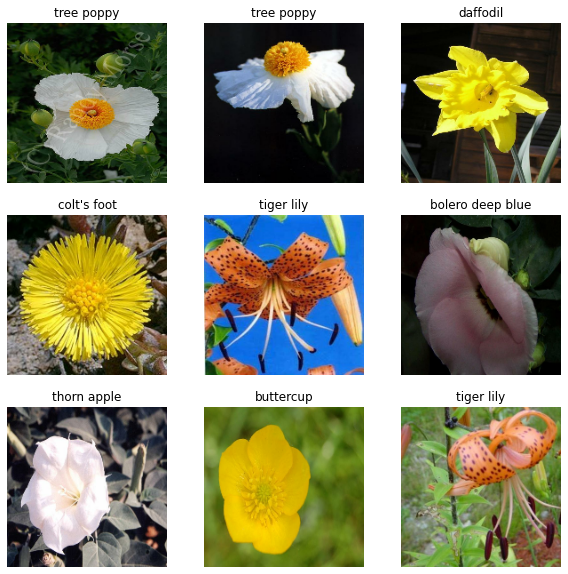

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Standardize the data

We will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training and evaluation

We'll create a simple CNN to classify the flowers. Before setting up the architecture, let's define some useful utilities.

### Callbacks

Reduce learning rate on plateau:

In [42]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=50, min_lr=1e-6)

Early stopping when loss stops decreasing:

In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

### Data augmentation

Since the dataset is small, we'll use data augmentation to improve training: flip, translation, rotation, and zoom.

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

Let's check some of the augmented images:

2023-05-09 16:31:37.014253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1020]
	 [[{{node Placeholder/_0}}]]
2023-05-09 16:31:37.014920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1020]
	 [[{{node Placeholder/_0}}]]
2023-05-09 16:31:37.131565: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

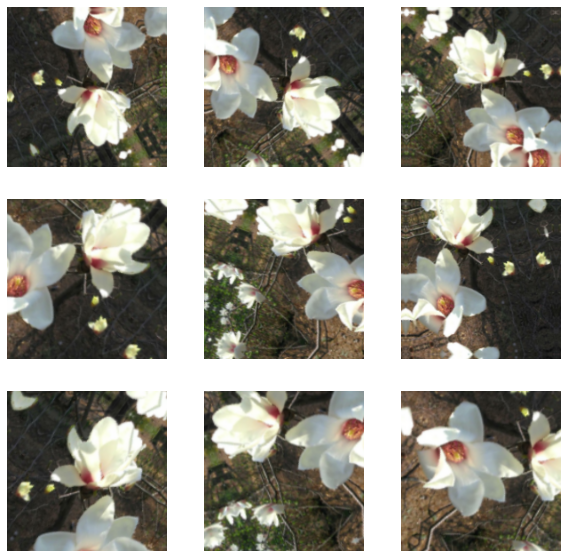

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating the model

Here we create the base model for classifying the flowers and to be used as reference in our experiments.

In [15]:
num_classes = 102
n_epochs = 300

def get_model():
  model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model = get_model()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Now we fit the model:

In [16]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0
)

2023-05-09 16:31:37.947759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1020]
	 [[{{node Placeholder/_4}}]]
2023-05-09 16:31:37.948054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1020]
	 [[{{node Placeholder/_0}}]]
2023-05-09 16:31:40.674851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-09 16:31:41.183190: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-09 16:31:41.303853: I tensorflow/compiler/xla/

And evaluate the model:

In [17]:
score = model.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score[1]:.3f}')

2023-05-09 16:32:59.243990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6149]
	 [[{{node Placeholder/_4}}]]
2023-05-09 16:32:59.244636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6149]
	 [[{{node Placeholder/_0}}]]


Test accuracy: 0.347


### Batch normalization

We'll also experiment on the use of batch normalization in comparison to applying color constancy. Let's define a model that includes the batch normalization layer.

In [18]:
def get_model_batchnorm():
  model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model_batchnorm = get_model_batchnorm()

model_batchnorm.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Fit the model:

In [19]:
model_batchnorm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0
)

And evaluate the model:

In [20]:
score = model_batchnorm.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score[1]:.3f}')

Test accuracy: 0.347


# 17 Flowers with Color Constancy (CC)

Now, we'll apply the same pipeline to the dataset after its been processed by color constancy models. There are two methods for this:
- use implemented CC models as Keras layers;
- use the CC'ed dataset, i.e. the 17 flowers dataset preprocessed by a CC model.

In the first case, we just add the layer to our model and fit it to the original dataset. In the second, we need to create new dataset variables using the new image files from the CC'ed dataset.

## CC as Keras layers - Grey World, White Patch, and Grey Edge

Let's start with the Keras layers.

In [21]:
from processing.grey_world.cc_layers import GreyWorld, WhitePatch, GreyEdge

grey_world_layer = GreyWorld()
white_patch_layer = WhitePatch()
grey_edge_layer = GreyEdge()

def get_cc_model(cc_layer):
  model = tf.keras.Sequential([
    normalization_layer,
    cc_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

/home/mf11800x/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Grey World:

In [22]:
cc_model_gw = get_cc_model(grey_world_layer)

cc_model_gw.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_gw.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_gw = cc_model_gw.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_gw[1]:.3f}')

Test accuracy: 0.313


White Patch:

In [23]:
cc_model_wp = get_cc_model(white_patch_layer)

cc_model_wp.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_wp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0)

score_cc_wp = cc_model_wp.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_wp[1]:.3f}')

Test accuracy: 0.337


Grey Edge:

In [24]:
cc_model_ge = get_cc_model(grey_edge_layer)

cc_model_ge.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_ge.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_ge = cc_model_ge.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_ge[1]:.3f}')

Test accuracy: 0.008


## CC'ed Dataset - FC4

Now we'll use the CC'ed Dataset preprocessed by the FC4 CC model.

In [26]:
path_to_data_cc = "data/17flowers/cc/"
create_subfolders(path_to_data_cc)
move_images_to_subfolders(path_to_data_cc)

train_dir_cc = pathlib.Path(path_to_data_cc + "train")
val_dir_cc = pathlib.Path(path_to_data_cc + "val")
test_dir_cc = pathlib.Path(path_to_data_cc + "test")

All subfolders created at data/17flowers/cc/.
Images copied successfully to data/17flowers/cc/.


In [27]:
train_ds_cc = tf.keras.utils.image_dataset_from_directory(
  train_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_cc = tf.keras.utils.image_dataset_from_directory(
  val_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds_cc = tf.keras.utils.image_dataset_from_directory(
  test_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 752 files belonging to 119 classes.
Found 412 files belonging to 119 classes.
Found 1556 files belonging to 119 classes.


This is how the dataset looks like:

2023-05-09 17:11:44.638044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [752]
	 [[{{node Placeholder/_4}}]]
2023-05-09 17:11:44.638383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [752]
	 [[{{node Placeholder/_0}}]]


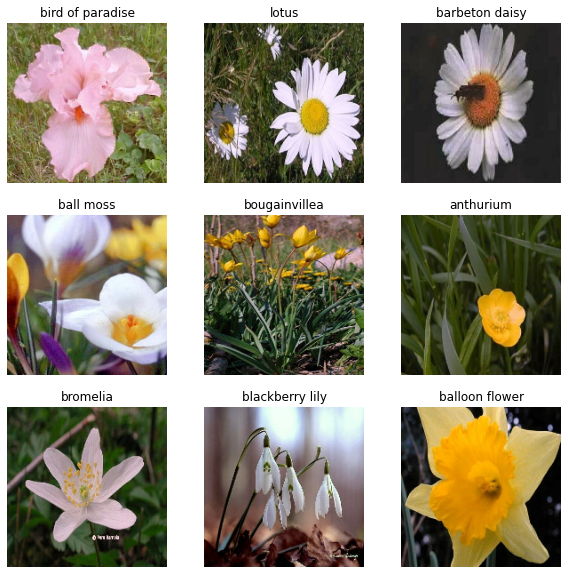

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_cc.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Finally, optimize the dataset for performance:

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cc = train_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_cc = val_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_cc = test_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)

Now we fit the model to the CC'ed dataset:

In [30]:
model_cc_fc4 = get_model()

model_cc_fc4.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model_cc_fc4.fit(
  train_ds_cc,
  validation_data=val_ds_cc,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_fc4 = model_cc_fc4.evaluate(test_ds_cc, verbose=0)
print(f'Test accuracy: {score_cc_fc4[1]:.3f}')

2023-05-09 17:11:45.269244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [752]
	 [[{{node Placeholder/_4}}]]
2023-05-09 17:11:45.269741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [752]
	 [[{{node Placeholder/_4}}]]
2023-05-09 17:11:48.737783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [412]
	 [

Test accuracy: 0.013


# Experiment

For the evaluation experiment, we'll run 10 trials of training/evaluation for each model. The collected data will be:
- time, accuracy, and loss for train, validation, and test;
- number of epochs

We'll compare all results with the base model.

In [31]:
import time

def experiment(model, train_ds, val_ds, test_ds, n_trials=10):
    metrics = {
        "train_time": [],
        "test_time": [],
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": [],
        "test_acc": [],
        "test_loss": [],
        "history": []
    }

    for i in range(n_trials):        
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        start_time = time.perf_counter()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=n_epochs,
            callbacks=[reduce_lr, early_stop],
            verbose=0)
        end_time = time.perf_counter()
        training_time = end_time - start_time

        start_time = time.perf_counter()
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        end_time = time.perf_counter()
        test_time = end_time - start_time

        metrics["train_time"].append(training_time)
        metrics["test_time"].append(test_time)
        metrics["train_acc"].append(history.history["accuracy"][-1])
        metrics["train_loss"].append(history.history["loss"][-1])
        metrics["val_acc"].append(history.history["val_accuracy"][-1])
        metrics["val_loss"].append(history.history["val_loss"][-1])
        metrics["test_acc"].append(test_acc)
        metrics["test_loss"].append(test_loss)
        metrics["history"].append(history)
    return metrics

In [32]:
# Create new models
model_base = get_model()
model_batch = get_model_batchnorm()
model_gw = get_cc_model(grey_world_layer)
model_ge = get_cc_model(grey_edge_layer)
model_wp = get_cc_model(white_patch_layer)
model_fc4 = get_model()

# Run experiments
n_trials = 3
metrics_base = experiment(model_base, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics_batch = experiment(model_batch, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics_gw = experiment(model_gw, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics_ge = experiment(model_ge, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics_wp = experiment(model_wp, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics_fc4 = experiment(model_fc4, train_ds_cc, val_ds_cc, test_ds_cc, n_trials=n_trials)

Now let's visualize the results.

In [33]:
def calc_y_limits(y, margin=0.15):
    """
        Return min and max values for the provided y values according to given margin.
        To be used with matplotlib `set_ylim()`.
    """
    y_min = np.min(y)
    y_max = np.max(y)
    y_range = y_max - y_min
    y_margin = margin * y_range
    y_min_limit = y_min - y_margin
    y_max_limit = y_max + y_margin
    return y_min_limit, y_max_limit


def add_history_avg(all_metrics, n_trials):
    """
        Add "history_avg" key to all provided metrics, which contains the average values
        for all the `history` objects inside the metric.

        Basically calculates averages of the training history so that they can be plotted.
    """
    for m in all_metrics:
        m["history_avg"] = {
        "accuracy": [],
        "loss": [],
        "val_accuracy": [],
        "val_loss": []
        }
        for kpi in m["history_avg"].keys():
            n_epochs = []
            for trial in range(n_trials):
                # Check all trials to find the one with most epochs. We'll calculate averages until the last epoch.
                n_epochs.append(len(m["history"][trial].history[kpi]))
            for epoch in range(max(n_epochs)):
                epoch_values = []
                epoch_count = 0
                for trial in range(n_trials):
                    try:
                        epoch_values.append(m["history"][trial].history[kpi][epoch])
                        epoch_count += 1
                    except IndexError:
                        # We skip counting when a trial has less epochs than the current epoch.
                        # Doing this causes abrupt changes to show up along the plot.
                        pass
                epoch_avg = sum(epoch_values)/epoch_count
                m["history_avg"][kpi].append(epoch_avg)

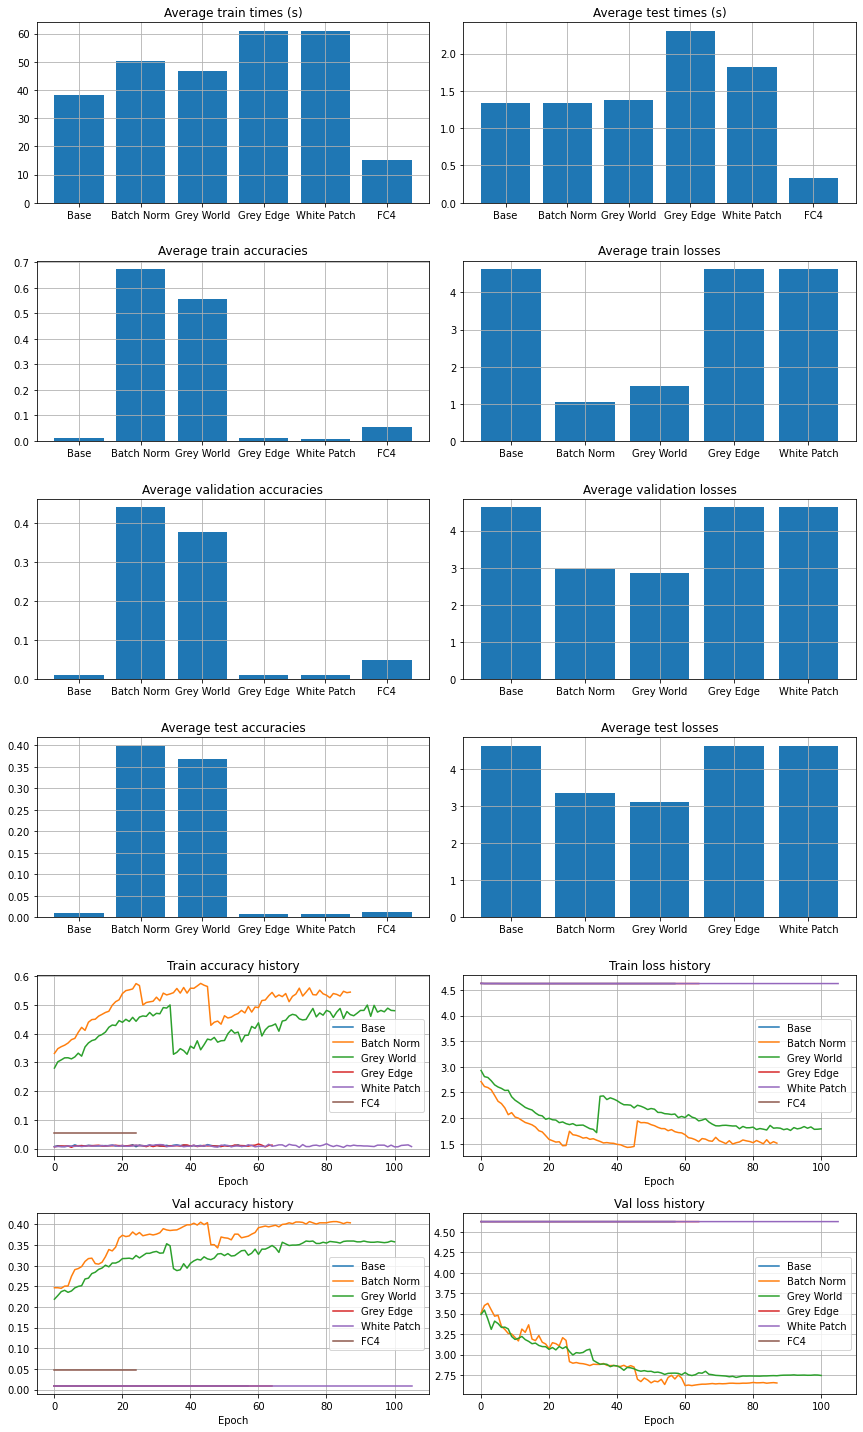

In [39]:
all_metrics = [metrics_base, metrics_batch, metrics_gw, metrics_ge, metrics_wp, metrics_fc4]

train_time_avg = [sum(m["train_time"])/n_trials for m in all_metrics]
test_time_avg = [sum(m["test_time"])/n_trials for m in all_metrics]
train_acc_avg = [sum(m["train_acc"])/n_trials for m in all_metrics]
train_loss_avg = [sum(m["train_loss"])/n_trials for m in all_metrics]
val_acc_avg = [sum(m["val_acc"])/n_trials for m in all_metrics]
val_loss_avg = [sum(m["val_loss"])/n_trials for m in all_metrics]
test_acc_avg = [sum(m["test_acc"])/n_trials for m in all_metrics]
test_loss_avg = [sum(m["test_loss"])/n_trials for m in all_metrics] 

add_history_avg(all_metrics, n_trials)

# Create a 4x2 grid of plots
nrows = 6
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 20))

# --- Plots
x_axis = ["Base", "Batch Norm", "Grey World", "Grey Edge", "White Patch", "FC4"]

# Time
axs[0, 0].bar(x_axis, train_time_avg)
axs[0, 0].set_title('Average train times (s)')
# y_limit = calc_y_limits(train_time_avg)
# axs[0, 0].set_ylim(y_limit[0], y_limit[1])

axs[0, 1].bar(x_axis, test_time_avg)
axs[0, 1].set_title('Average test times (s)')
# y_limit = calc_y_limits(test_time_avg)
# axs[0, 1].set_ylim(y_limit[0], y_limit[1])

# Train acc and loss
axs[1, 0].bar(x_axis, train_acc_avg)
axs[1, 0].set_title('Average train accuracies')
# y_limit = calc_y_limits(train_acc_avg)
# axs[1, 0].set_ylim(y_limit[0], y_limit[1])

axs[1, 1].bar(x_axis, train_loss_avg)
axs[1, 1].set_title('Average train losses')
# y_limit = calc_y_limits(train_loss_avg)
# axs[1, 1].set_ylim(y_limit[0], y_limit[1])

# Validation acc and loss
axs[2, 0].bar(x_axis, val_acc_avg)
axs[2, 0].set_title('Average validation accuracies')
# y_limit = calc_y_limits(val_acc_avg)
# axs[2, 0].set_ylim(y_limit[0], y_limit[1])

axs[2, 1].bar(x_axis, val_loss_avg)
axs[2, 1].set_title('Average validation losses')
# y_limit = calc_y_limits(val_loss_avg)
# axs[2, 1].set_ylim(y_limit[0], y_limit[1])

# Test acc and loss
axs[3, 0].bar(x_axis, test_acc_avg)
axs[3, 0].set_title('Average test accuracies')
# y_limit = calc_y_limits(test_acc_avg)
# axs[3, 0].set_ylim(y_limit[0], y_limit[1])

axs[3, 1].bar(x_axis, test_loss_avg)
axs[3, 1].set_title('Average test losses')
# y_limit = calc_y_limits(test_loss_avg)
# axs[3, 1].set_ylim(y_limit[0], y_limit[1])

# History
for m in all_metrics:
    axs[4, 0].plot(m["history_avg"]["accuracy"], label=x_axis[all_metrics.index(m)])
    axs[4, 1].plot(m["history_avg"]["loss"], label=x_axis[all_metrics.index(m)])
    axs[5, 0].plot(m["history_avg"]["val_accuracy"], label=x_axis[all_metrics.index(m)])
    axs[5, 1].plot(m["history_avg"]["val_loss"], label=x_axis[all_metrics.index(m)])
axs[4, 0].set_title('Train accuracy history')
axs[4, 0].legend()
axs[4, 1].set_title('Train loss history')
axs[4, 1].legend()
axs[5, 0].set_title('Val accuracy history')
axs[5, 0].legend()
axs[5, 1].set_title('Val loss history')
axs[5, 1].legend()

for i in range(4, nrows):
    for j in range(ncols):
        axs[i, j].set_xlabel("Epoch")

# Enable grid
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].grid()

# Add some spacing between the plots
fig.tight_layout()

# Save plot to PNG file
plt.savefig('./out/102f_experiment_plots.png')

# Display the plot
plt.show()

Now let's prepare a pandas dataframe and save the data to an excel sheet.

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "model": x_axis,
    "train_time_avg": train_time_avg,
    "test_time_avg": test_time_avg,
    "train_acc_avg": train_acc_avg,
    "train_loss_avg": train_loss_avg,
    "val_acc_avg": val_acc_avg,
    "val_loss_avg": val_loss_avg,
    "test_acc_avg": test_acc_avg,
    "test_loss_avg": test_loss_avg,
})

for kpi in metrics_base.keys():
    if kpi == "history" or kpi == "history_avg":
        continue
    df[f"{kpi}_min"] = [min(m[kpi]) for m in all_metrics]
    df[f"{kpi}_max"] = [max(m[kpi]) for m in all_metrics]
    df[f"{kpi}_std"] = [np.std(m[kpi]) for m in all_metrics]
    
for key in metrics_base["history_avg"].keys():
    df[f"history_avg_{key}"] = [m["history_avg"][key] for m in all_metrics]

df.head()

,model,train_time_avg,test_time_avg,train_acc_avg,train_loss_avg,val_acc_avg,val_loss_avg,test_acc_avg,test_loss_avg,train_time_min,...,test_acc_min,test_acc_max,test_acc_std,test_loss_min,test_loss_max,test_loss_std,history_avg_accuracy,history_avg_loss,history_avg_val_accuracy,history_avg_val_loss
0,Base,29.333822,0.081348,0.823529,0.486089,0.707353,1.034828,0.760294,0.901607,24.924588,...,0.741176,0.779412,0.019118,0.897098,0.906115,0.004509,"[0.35514706559479237, 0.41397058218717575, 0.4...","[1.9277477264404297, 1.7116371095180511, 1.649...","[0.37794118002057076, 0.37647057697176933, 0.3...","[1.9229152202606201, 1.8047093152999878, 1.764..."
1,Batch Norm,30.263944,0.084953,0.851471,0.421739,0.714706,1.075647,0.730882,0.841790,24.341911,...,0.726471,0.735294,0.004412,0.838111,0.845468,0.003678,"[0.39926470071077347, 0.43602941930294037, 0.4...","[1.8147137761116028, 1.567887008190155, 1.5213...","[0.3897058703005314, 0.3911764770746231, 0.402...","[1.930106282234192, 1.9112014770507812, 1.8572..."
2,Grey World,28.175084,0.085743,0.797794,0.565314,0.695588,1.055589,0.739706,0.842705,21.572865,...,0.714706,0.764706,0.025000,0.825938,0.859472,0.016767,"[0.3794117644429207, 0.40367645770311356, 0.42...","[1.8422871232032776, 1.7245546579360962, 1.635...","[0.41470587998628616, 0.3955882266163826, 0.42...","[1.8696893453598022, 1.883135199546814, 1.7394..."
3,Grey Edge,70.375119,0.142999,0.728676,0.784834,0.650000,1.186158,0.707353,0.986445,26.650378,...,0.679412,0.735294,0.027941,0.941044,1.031847,0.045402,"[0.28676471672952175, 0.3323529548943043, 0.37...","[2.1289637684822083, 2.0020798444747925, 1.819...","[0.3088235277682543, 0.3529411666095257, 0.376...","[2.060113251209259, 1.9513353109359741, 1.8988..."
4,White Patch,33.651298,0.104854,0.770588,0.639798,0.719118,0.971766,0.775000,0.762137,20.940720,...,0.767647,0.782353,0.007353,0.740641,0.783634,0.021497,"[0.3602941147983074, 0.3845588341355324, 0.424...","[1.897733747959137, 1.7761472463607788, 1.6926...","[0.41470588743686676, 0.37205882743000984, 0.4...","[1.8046579957008362, 1.7925817966461182, 1.724..."


Export to Excel:

In [ ]:
df.to_excel('experiment_results.xlsx', index=False)

# Tensorboard

We can use Tensorboard to visualize training data for a model.

In [51]:
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
n_epochs = 1000
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=1e-6)

def run_with_tensorboard(model, train_ds, val_ds):
    model.compile(
        optimizer=Adam(lr=0.01),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=n_epochs,
        callbacks=[reduce_lr, early_stop, tensorboard], 
        verbose=0)

To open Tensorboard, run the following in the terminal:

```sh
tensorboard logsdir=./logs
```

If `tensorboard` is not in `PATH`, you can use the path to the binary instead. VS Code has Tensorboard integration, so it can also be used.

In [52]:
model_tensorboard = get_model()

run_with_tensorboard(model_tensorboard, train_ds, val_ds)

/home/mf11800x/.local/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
